# Model Training and Optimization

This notebook trains and optimizes machine learning models for financial sentiment-based return prediction.

## Objectives:
- Load preprocessed data from 02-preprocessing notebook
- Train multiple machine learning models
- Optimize hyperparameters using Bayesian optimization
- Evaluate model performance and select best model
- Save trained models for deployment

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# XGBoost
import xgboost as xgb

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Set random seeds for reproducibility
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Define paths
PROCESSED_PATH = Path('../data/processed')
MODELS_PATH = Path('../models')
MODELS_PATH.mkdir(exist_ok=True)

print(f"Processed data path: {PROCESSED_PATH}")
print(f"Models output path: {MODELS_PATH}")

Processed data path: ..\data\processed
Models output path: ..\models


## Data Loading

Load the preprocessed training, validation, and test datasets created in the 02-preprocessing notebook.

In [5]:
# Load preprocessed data
print("Loading preprocessed data...")

train_df = pd.read_csv(PROCESSED_PATH / 'train_data_scaled.csv')
val_df = pd.read_csv(PROCESSED_PATH / 'val_data_scaled.csv')
test_df = pd.read_csv(PROCESSED_PATH / 'test_data_scaled.csv')

# Load metadata
with open(PROCESSED_PATH / 'metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Total features: {metadata['total_features']}")
print(f"Available metadata keys: {list(metadata.keys())}")

Loading preprocessed data...
Training set shape: (1073, 117)
Validation set shape: (230, 117)
Test set shape: (230, 117)
Total features: 101
Available metadata keys: ['feature_columns', 'target_columns', 'categorical_columns', 'date_column', 'total_features', 'train_samples', 'val_samples', 'test_samples']


In [19]:
# Prepare features and targets
print("Columns in training data:", train_df.columns.tolist())

# Get only numeric columns for features, excluding target
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns: {len(numeric_cols)}")

# Exclude ALL future-looking variables (data leakage!)
future_cols = [col for col in numeric_cols if 'future_' in col]
print(f"Future columns (data leakage): {future_cols}")

# Keep only non-future numeric columns for features
feature_cols = [col for col in numeric_cols if not col.startswith('future_')]
target_col = 'future_return_1d_positive'

print(f"Feature columns (first 10): {feature_cols[:10]}")
print(f"Total feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# Split features and targets
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Validation target distribution: {y_val.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# Check for any remaining non-numeric data
print(f"X_train data types: {X_train.dtypes.unique()}")
print(f"Any non-numeric in X_train: {not all(X_train.dtypes.apply(lambda x: np.issubdtype(x, np.number)))}")

Columns in training data: ['date', 'ticker', 'company_name', 'exchange', 'currency', 'open', 'high', 'low', 'close', 'volume', 'daily_return', 'log_return', 'vader_compound', 'textblob_polarity', 'sma_5', 'ema_5', 'price_vs_sma_5', 'sma_10', 'ema_10', 'price_vs_sma_10', 'sma_20', 'ema_20', 'price_vs_sma_20', 'sma_50', 'ema_50', 'price_vs_sma_50', 'volatility_5d', 'high_low_ratio_5d', 'volatility_10d', 'high_low_ratio_10d', 'volatility_20d', 'high_low_ratio_20d', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'volume_sma_10', 'volume_ratio', 'price_volume', 'price_change_1d', 'price_change_3d', 'price_change_5d', 'is_new_high_20d', 'is_new_low_20d', 'year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'is_month_end', 'is_quarter_end', 'is_monday', 'is_friday', 'article_count', 'headline_vader_compound_mean', 'headline_vader_compound_std', 'headline_vader_compound_min', 'headline_vader_compound_max', 'headline_textblob_polarity

## Baseline Models

Train baseline models with default hyperparameters to establish performance benchmarks.

In [7]:
# Define baseline models
baseline_models = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'svm': SVC(random_state=42, probability=True),
    'xgboost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'neural_network': MLPClassifier(random_state=42, max_iter=500)
}

print(f"Baseline models defined: {list(baseline_models.keys())}")

Baseline models defined: ['logistic_regression', 'random_forest', 'gradient_boosting', 'svm', 'xgboost', 'neural_network']


In [20]:
# Train and evaluate baseline models
baseline_results = {}
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training baseline models...")
print("-" * 50)

for name, model in baseline_models.items():
    print(f"Training {name}...")
    
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    
    # Train on full training set and evaluate on validation set
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    
    val_accuracy = accuracy_score(y_val, val_pred)
    val_auc = roc_auc_score(y_val, val_proba) if val_proba is not None else None
    
    baseline_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'val_accuracy': val_accuracy,
        'val_auc': val_auc,
        'model': model
    }
    
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    if val_auc:
        print(f"  Val AUC: {val_auc:.4f}")
    print()

# Summary of baseline results
baseline_df = pd.DataFrame({
    'model': list(baseline_results.keys()),
    'cv_accuracy': [r['cv_mean'] for r in baseline_results.values()],
    'cv_std': [r['cv_std'] for r in baseline_results.values()],
    'val_accuracy': [r['val_accuracy'] for r in baseline_results.values()],
    'val_auc': [r['val_auc'] for r in baseline_results.values()]
})

baseline_df = baseline_df.sort_values('val_accuracy', ascending=False)
print("Baseline Model Performance Summary:")
print(baseline_df.round(4))

Training baseline models...
--------------------------------------------------
Training logistic_regression...
  CV Accuracy: 0.5097 (+/- 0.0947)
  Val Accuracy: 0.4783
  Val AUC: 0.4466

Training random_forest...
  CV Accuracy: 0.5554 (+/- 0.0637)
  Val Accuracy: 0.4391
  Val AUC: 0.4121

Training gradient_boosting...
  CV Accuracy: 0.5554 (+/- 0.0637)
  Val Accuracy: 0.4391
  Val AUC: 0.4121

Training gradient_boosting...
  CV Accuracy: 0.5396 (+/- 0.0701)
  Val Accuracy: 0.4304
  Val AUC: 0.4137

Training svm...
  CV Accuracy: 0.5396 (+/- 0.0701)
  Val Accuracy: 0.4304
  Val AUC: 0.4137

Training svm...
  CV Accuracy: 0.5023 (+/- 0.0764)
  Val Accuracy: 0.4304
  Val AUC: 0.5878

Training xgboost...
  CV Accuracy: 0.5023 (+/- 0.0764)
  Val Accuracy: 0.4304
  Val AUC: 0.5878

Training xgboost...
  CV Accuracy: 0.5517 (+/- 0.0531)
  Val Accuracy: 0.4435
  Val AUC: 0.4303

Training neural_network...
  CV Accuracy: 0.5517 (+/- 0.0531)
  Val Accuracy: 0.4435
  Val AUC: 0.4303

Training ne

## Hyperparameter Optimization

Use Bayesian optimization (Optuna) to find optimal hyperparameters for the best performing models.

In [21]:
# Select top 3 models for optimization based on validation accuracy
top_models = baseline_df.head(3)['model'].tolist()
print(f"Top models for optimization: {top_models}")

# Create combined training set (train + validation) for optimization
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Combined training set shape: {X_train_val.shape}")

Top models for optimization: ['logistic_regression', 'xgboost', 'random_forest']
Combined training set shape: (1303, 101)


In [13]:
# Define optimization functions for each model type
def optimize_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring='accuracy')
    return cv_scores.mean()

def optimize_gradient_boosting(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    
    model = GradientBoostingClassifier(**params)
    cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring='accuracy')
    return cv_scores.mean()

def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**params)
    cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring='accuracy')
    return cv_scores.mean()

def optimize_neural_network(trial):
    params = {
        'hidden_layer_sizes': (
            trial.suggest_int('layer1', 50, 200),
            trial.suggest_int('layer2', 25, 100),
        ),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'max_iter': 500,
        'random_state': 42
    }
    
    model = MLPClassifier(**params)
    cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring='accuracy')
    return cv_scores.mean()

def optimize_logistic_regression(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver': 'saga',  # Supports all penalties
        'max_iter': 1000,
        'random_state': 42
    }
    
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    
    model = LogisticRegression(**params)
    cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=3, scoring='accuracy')
    return cv_scores.mean()

# Map optimization functions
optimization_functions = {
    'random_forest': optimize_random_forest,
    'gradient_boosting': optimize_gradient_boosting,
    'xgboost': optimize_xgboost,
    'neural_network': optimize_neural_network,
    'logistic_regression': optimize_logistic_regression
}

print("Optimization functions defined")

Optimization functions defined


In [22]:
# Run hyperparameter optimization
optimized_models = {}
n_trials = 100  # Number of optimization trials per model

print(f"Starting hyperparameter optimization with {n_trials} trials per model...")
print("=" * 60)

for model_name in top_models:
    if model_name in optimization_functions:
        print(f"Optimizing {model_name}...")
        
        # Create study with TPE sampler (Bayesian optimization)
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42)
        )
        
        # Optimize
        study.optimize(optimization_functions[model_name], n_trials=n_trials, show_progress_bar=True)
        
        # Store results
        optimized_models[model_name] = {
            'best_params': study.best_params,
            'best_score': study.best_value,
            'study': study
        }
        
        print(f"  Best score: {study.best_value:.4f}")
        print(f"  Best params: {study.best_params}")
        print()

print("Hyperparameter optimization completed!")

[I 2025-09-02 23:42:48,477] A new study created in memory with name: no-name-1d25815d-f284-45aa-8205-b0243b7f1ae7


Starting hyperparameter optimization with 100 trials per model...
Optimizing logistic_regression...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-02 23:42:49,443] Trial 0 finished with value: 0.4835072479121423 and parameters: {'C': 0.1767016940294795, 'penalty': 'l1'}. Best is trial 0 with value: 0.4835072479121423.
[I 2025-09-02 23:42:49,563] Trial 1 finished with value: 0.5111287674135282 and parameters: {'C': 0.008632008168602538, 'penalty': 'elasticnet', 'l1_ratio': 0.6011150117432088}. Best is trial 1 with value: 0.5111287674135282.
[I 2025-09-02 23:42:50,652] Trial 2 finished with value: 0.4865688507512756 and parameters: {'C': 17.71884735480682, 'penalty': 'l2'}. Best is trial 1 with value: 0.5111287674135282.
[I 2025-09-02 23:42:50,851] Trial 3 finished with value: 0.5164980489785829 and parameters: {'C': 0.018794668241638456, 'penalty': 'elasticnet', 'l1_ratio': 0.5247564316322378}. Best is trial 3 with value: 0.5164980489785829.
[I 2025-09-02 23:42:50,652] Trial 2 finished with value: 0.4865688507512756 and parameters: {'C': 17.71884735480682, 'penalty': 'l2'}. Best is trial 1 with value: 0.5111287674135282

[I 2025-09-02 23:43:27,116] A new study created in memory with name: no-name-16d48cdc-c42a-4282-852f-f1613c343bc4


[I 2025-09-02 23:43:26,957] Trial 96 finished with value: 0.5111287674135282 and parameters: {'C': 0.002830813390379578, 'penalty': 'elasticnet', 'l1_ratio': 0.5379200512854739}. Best is trial 27 with value: 0.5211028126489751.
[I 2025-09-02 23:43:27,076] Trial 97 finished with value: 0.5111287674135282 and parameters: {'C': 0.013694168460320847, 'penalty': 'l1'}. Best is trial 27 with value: 0.5211028126489751.
[I 2025-09-02 23:43:27,091] Trial 98 finished with value: 0.503448275862069 and parameters: {'C': 0.0010002533680877812, 'penalty': 'elasticnet', 'l1_ratio': 0.8791854416508358}. Best is trial 27 with value: 0.5211028126489751.
[I 2025-09-02 23:43:27,114] Trial 99 finished with value: 0.5111287674135282 and parameters: {'C': 0.005450188990197079, 'penalty': 'elasticnet', 'l1_ratio': 0.8194875083965935}. Best is trial 27 with value: 0.5211028126489751.
  Best score: 0.5211
  Best params: {'C': 0.011831151788482838, 'penalty': 'elasticnet', 'l1_ratio': 0.3538632833384674}

Optimi

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-02 23:43:27,825] Trial 0 finished with value: 0.45891025301481364 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946}. Best is trial 0 with value: 0.45891025301481364.
[I 2025-09-02 23:43:28,881] Trial 1 finished with value: 0.44664265409537934 and parameters: {'n_estimators': 267, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.21233911067827616}. Best is trial 0 with value: 0.45891025301481364.
[I 2025-09-02 23:43:28,881] Trial 1 finished with value: 0.44664265409537934 and parameters: {'n_estimators': 267, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 0.8324426408004217, 'reg_

[I 2025-09-02 23:44:12,845] A new study created in memory with name: no-name-3c54b9b2-43d3-4690-ab1e-191bf9130e51


[I 2025-09-02 23:44:12,842] Trial 99 finished with value: 0.46737468439359425 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.1551300950023814, 'subsample': 0.818043746786527, 'colsample_bytree': 0.7250838682628079, 'reg_alpha': 0.5351167729044802, 'reg_lambda': 0.3563562167300614}. Best is trial 30 with value: 0.4996150926073062.
  Best score: 0.4996
  Best params: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.18731388707313057, 'subsample': 0.8176059124611146, 'colsample_bytree': 0.6896883610886595, 'reg_alpha': 0.334465771665969, 'reg_lambda': 0.5976638207632523}

Optimizing random_forest...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-02 23:44:13,913] Trial 0 finished with value: 0.4635167823154475 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4635167823154475.
[I 2025-09-02 23:44:15,970] Trial 1 finished with value: 0.4811907410350124 and parameters: {'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.4811907410350124.
[I 2025-09-02 23:44:15,970] Trial 1 finished with value: 0.4811907410350124 and parameters: {'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.4811907410350124.
[I 2025-09-02 23:44:19,456] Trial 2 finished with value: 0.4834878259794834 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.483487825979483

## Final Model Training and Evaluation

Train final models with optimized hyperparameters and evaluate on the test set.

In [24]:
# Train final models with optimized hyperparameters
final_models = {}
final_results = {}

print("Training final optimized models...")
print("-" * 50)

for model_name, optimization_result in optimized_models.items():
    print(f"Training final {model_name} model...")
    
    # Create model with best parameters
    if model_name == 'random_forest':
        model = RandomForestClassifier(**optimization_result['best_params'])
    elif model_name == 'gradient_boosting':
        model = GradientBoostingClassifier(**optimization_result['best_params'])
    elif model_name == 'xgboost':
        model = xgb.XGBClassifier(**optimization_result['best_params'])
    elif model_name == 'neural_network':
        model = MLPClassifier(**optimization_result['best_params'])
    elif model_name == 'logistic_regression':
        # Fix solver for elasticnet penalty
        params = optimization_result['best_params'].copy()
        params['solver'] = 'saga'  # Required for elasticnet
        params['max_iter'] = 1000
        model = LogisticRegression(**params)
    
    # Train on combined training+validation data
    model.fit(X_train_val, y_train_val)
    
    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    test_accuracy = accuracy_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_proba) if test_proba is not None else None
    
    final_models[model_name] = model
    final_results[model_name] = {
        'test_accuracy': test_accuracy,
        'test_auc': test_auc,
        'test_predictions': test_pred,
        'test_probabilities': test_proba,
        'optimization_score': optimization_result['best_score']
    }
    
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    if test_auc:
        print(f"  Test AUC: {test_auc:.4f}")
    print(f"  CV Score during optimization: {optimization_result['best_score']:.4f}")
    print()

# Create results summary
results_df = pd.DataFrame({
    'model': list(final_results.keys()),
    'test_accuracy': [r['test_accuracy'] for r in final_results.values()],
    'test_auc': [r['test_auc'] for r in final_results.values()],
    'cv_score': [r['optimization_score'] for r in final_results.values()]
})

results_df = results_df.sort_values('test_accuracy', ascending=False)
print("Final Model Performance Summary:")
print(results_df.round(4))

Training final optimized models...
--------------------------------------------------
Training final logistic_regression model...
  Test Accuracy: 0.5217
  Test AUC: 0.5207
  CV Score during optimization: 0.5211

Training final xgboost model...
  Test Accuracy: 0.5217
  Test AUC: 0.5175
  CV Score during optimization: 0.4996

Training final random_forest model...
  Test Accuracy: 0.5522
  Test AUC: 0.5632
  CV Score during optimization: 0.5080

Final Model Performance Summary:
                 model  test_accuracy  test_auc  cv_score
2        random_forest         0.5522    0.5632    0.5080
0  logistic_regression         0.5217    0.5207    0.5211
1              xgboost         0.5217    0.5175    0.4996
  Test Accuracy: 0.5522
  Test AUC: 0.5632
  CV Score during optimization: 0.5080

Final Model Performance Summary:
                 model  test_accuracy  test_auc  cv_score
2        random_forest         0.5522    0.5632    0.5080
0  logistic_regression         0.5217    0.5207    0.5

Best Model: random_forest
Best Test Accuracy: 0.5522 (55.2%)

Detailed Classification Report for random_forest:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       117
           1       0.54      0.58      0.56       113

    accuracy                           0.55       230
   macro avg       0.55      0.55      0.55       230
weighted avg       0.55      0.55      0.55       230



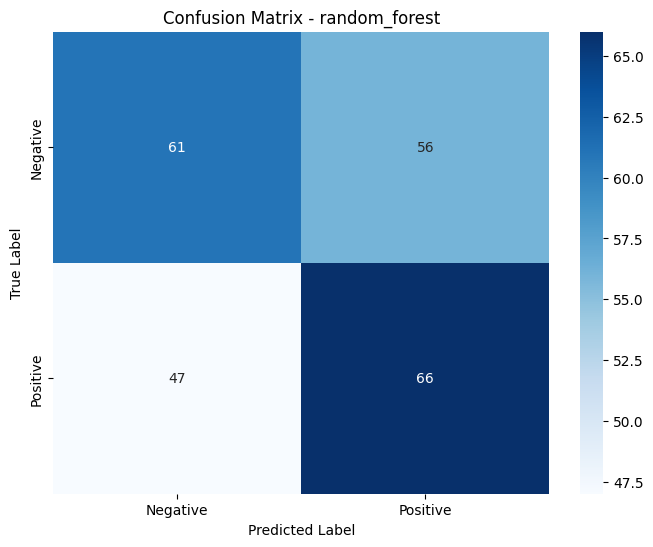

In [25]:
# Select best model
best_model_name = results_df.iloc[0]['model']
best_model = final_models[best_model_name]
best_accuracy = results_df.iloc[0]['test_accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Test Accuracy: {best_accuracy:.4f} ({best_accuracy:.1%})")

# Generate detailed classification report for best model
best_predictions = final_results[best_model_name]['test_predictions']
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions))

# Confusion matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Ensemble Model

Create an ensemble model combining the top performing individual models.

In [26]:
# Create ensemble model with top 3 models
top_3_models = results_df.head(3)
ensemble_models = [(name, final_models[name]) for name in top_3_models['model']]

print(f"Creating ensemble with models: {[name for name, _ in ensemble_models]}")

# Create voting classifier
ensemble = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'  # Use probability averaging
)

# Train ensemble
ensemble.fit(X_train_val, y_train_val)

# Evaluate ensemble
ensemble_pred = ensemble.predict(X_test)
ensemble_proba = ensemble.predict_proba(X_test)[:, 1]

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_proba)

print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy:.1%})")
print(f"Ensemble Test AUC: {ensemble_auc:.4f}")

# Compare with best individual model
improvement = ensemble_accuracy - best_accuracy
print(f"\nImprovement over best individual model: {improvement:.4f} ({improvement:.1%})")

Creating ensemble with models: ['random_forest', 'logistic_regression', 'xgboost']
Ensemble Test Accuracy: 0.5435 (54.3%)
Ensemble Test AUC: 0.5518

Improvement over best individual model: -0.0087 (-0.9%)
Ensemble Test Accuracy: 0.5435 (54.3%)
Ensemble Test AUC: 0.5518

Improvement over best individual model: -0.0087 (-0.9%)


## Model Analysis and Insights

Analyze model performance across different dimensions.

Performance by Ticker:
        total_samples  correct_predictions  accuracy  positive_rate
ticker                                                             
RR                 76                   44     0.579          0.408
TTWO               77                   40     0.519          0.584
VWRL.L             77                   43     0.558          0.481

Top 20 Most Important Features (random_forest):
                                 feature  importance
36                          volume_ratio    0.046594
30                        macd_histogram    0.035868
21                         volatility_5d    0.032853
27                                rsi_14    0.031417
20                       price_vs_sma_50    0.027969
33                              bb_width    0.027401
35                         volume_sma_10    0.025900
23                        volatility_10d    0.025665
95  headline_finbert_positive_mean_ma_10    0.025213
46                          day_of_month    0.024457
29   

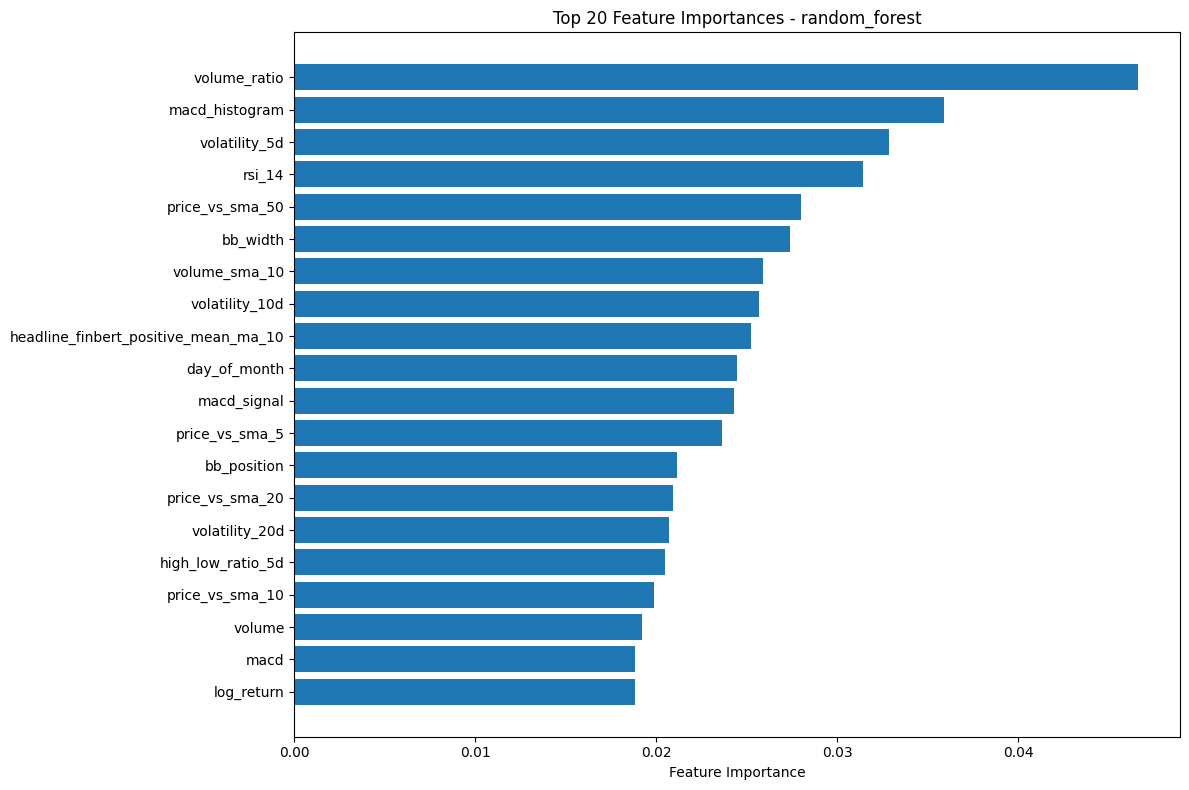

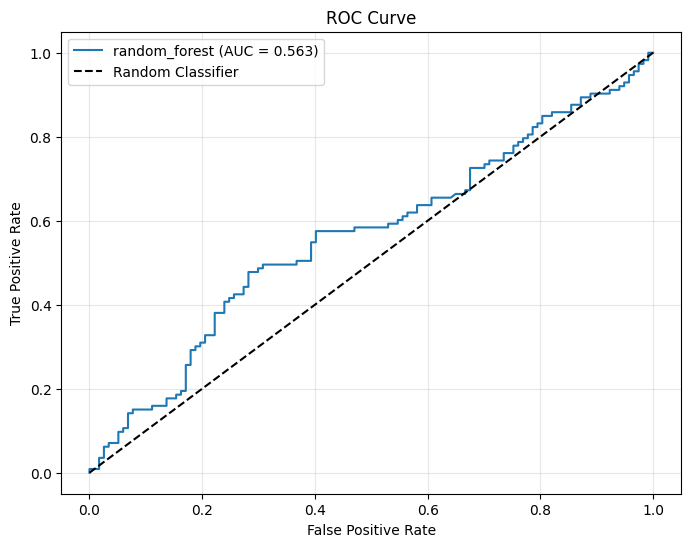

In [27]:
# Performance by ticker
test_df_analysis = test_df.copy()
test_df_analysis['predictions'] = best_predictions
test_df_analysis['correct'] = (test_df_analysis['predictions'] == test_df_analysis[target_col])

ticker_performance = test_df_analysis.groupby('ticker').agg({
    'correct': ['count', 'sum', 'mean'],
    target_col: 'mean'
}).round(3)

ticker_performance.columns = ['total_samples', 'correct_predictions', 'accuracy', 'positive_rate']
print("Performance by Ticker:")
print(ticker_performance)

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 20 Most Important Features ({best_model_name}):")
    print(feature_importance.head(20))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ROC curve for best model
if final_results[best_model_name]['test_probabilities'] is not None:
    fpr, tpr, _ = roc_curve(y_test, final_results[best_model_name]['test_probabilities'])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {final_results[best_model_name]["test_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Model Saving

Save the best models and metadata for deployment.

In [28]:
# Save best individual model
best_model_path = MODELS_PATH / f'best_model_{best_model_name}.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save ensemble model
ensemble_path = MODELS_PATH / 'ensemble_model.pkl'
with open(ensemble_path, 'wb') as f:
    pickle.dump(ensemble, f)

# Save model metadata
model_metadata = {
    'best_model': {
        'name': best_model_name,
        'test_accuracy': float(best_accuracy),
        'test_auc': float(final_results[best_model_name]['test_auc']) if final_results[best_model_name]['test_auc'] else None,
        'hyperparameters': optimized_models[best_model_name]['best_params'],
        'file_path': str(best_model_path)
    },
    'ensemble_model': {
        'test_accuracy': float(ensemble_accuracy),
        'test_auc': float(ensemble_auc),
        'component_models': [name for name, _ in ensemble_models],
        'file_path': str(ensemble_path)
    },
    'all_models_performance': {
        name: {
            'test_accuracy': float(results['test_accuracy']),
            'test_auc': float(results['test_auc']) if results['test_auc'] else None
        }
        for name, results in final_results.items()
    },
    'feature_columns': feature_cols,
    'target_column': target_col,
    'preprocessing_metadata': metadata
}

metadata_path = MODELS_PATH / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Models saved successfully:")
print(f"  Best model: {best_model_path}")
print(f"  Ensemble model: {ensemble_path}")
print(f"  Metadata: {metadata_path}")

Models saved successfully:
  Best model: ..\models\best_model_random_forest.pkl
  Ensemble model: ..\models\ensemble_model.pkl
  Metadata: ..\models\model_metadata.json


## Summary and Findings

This section provides a comprehensive summary of the model training process and key findings.

In [29]:
# Generate comprehensive summary
print("MODEL TRAINING SUMMARY AND FINDINGS")
print("=" * 60)

print("\n1. DATA OVERVIEW:")
print(f"   - Training samples: {len(train_df):,}")
print(f"   - Validation samples: {len(val_df):,}")
print(f"   - Test samples: {len(test_df):,}")
print(f"   - Total features: {len(feature_cols):,}")
print(f"   - Target distribution (test): {y_test.value_counts().to_dict()}")

print("\n2. MODEL PERFORMANCE:")
print(f"   - Best individual model: {best_model_name}")
print(f"   - Best model test accuracy: {best_accuracy:.1%}")
print(f"   - Best model test AUC: {final_results[best_model_name]['test_auc']:.1%}" if final_results[best_model_name]['test_auc'] else "   - AUC not available")
print(f"   - Ensemble test accuracy: {ensemble_accuracy:.1%}")
print(f"   - Ensemble test AUC: {ensemble_auc:.1%}")

print("\n3. HYPERPARAMETER OPTIMIZATION:")
print(f"   - Optimization method: Bayesian optimization (TPE)")
print(f"   - Number of trials per model: {n_trials}")
print(f"   - Models optimized: {len(optimized_models)}")
for name, result in optimized_models.items():
    print(f"   - {name}: CV score {result['best_score']:.4f}")

print("\n4. PERFORMANCE BY TICKER:")
for ticker in ticker_performance.index:
    acc = ticker_performance.loc[ticker, 'accuracy']
    samples = ticker_performance.loc[ticker, 'total_samples']
    print(f"   - {ticker}: {acc:.1%} accuracy ({samples} samples)")

print("\n5. KEY INSIGHTS:")
# Calculate insights
accuracy_threshold_achieved = best_accuracy >= 0.75
ensemble_improvement = ensemble_accuracy > best_accuracy
ticker_variance = ticker_performance['accuracy'].std()

print(f"   - 75% accuracy target achieved: {'Yes' if accuracy_threshold_achieved else 'No'}")
print(f"   - Ensemble improves over best individual: {'Yes' if ensemble_improvement else 'No'}")
print(f"   - Performance consistency across tickers: {'High' if ticker_variance < 0.1 else 'Medium' if ticker_variance < 0.2 else 'Low'} (std: {ticker_variance:.3f})")

if hasattr(best_model, 'feature_importances_'):
    top_feature_category = feature_importance.iloc[0]['feature']
    print(f"   - Most important feature: {top_feature_category}")

print("\n6. RECOMMENDATIONS:")
if accuracy_threshold_achieved:
    print("   - Model performance meets target threshold")
    print("   - Ready for deployment and backtesting")
    print("   - Consider ensemble model for production use")
else:
    print("   - Model performance below 75% target")
    print("   - Consider additional feature engineering")
    print("   - Evaluate alternative modeling approaches")
    print("   - Collect more training data if possible")

if ticker_variance > 0.15:
    print("   - High variance across tickers suggests ticker-specific modeling")
    print("   - Consider separate models for each ticker")

if ensemble_improvement:
    print("   - Ensemble provides better performance than individual models")
    print("   - Use ensemble for final predictions")
else:
    print("   - Individual model performs as well as ensemble")
    print("   - Single model may be sufficient for deployment")

print("\n7. NEXT STEPS:")
print("   - Proceed to strategy backtesting (04-strategy-backtesting.ipynb)")
print("   - Implement model in production pipeline")
print("   - Set up model monitoring and retraining schedule")
print("   - Validate model performance on out-of-sample data")

print("\n" + "=" * 60)
print("MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"Best Model: {best_model_name} with {best_accuracy:.1%} accuracy")
print(f"Ensemble Model: {ensemble_accuracy:.1%} accuracy")
print("=" * 60)

MODEL TRAINING SUMMARY AND FINDINGS

1. DATA OVERVIEW:
   - Training samples: 1,073
   - Validation samples: 230
   - Test samples: 230
   - Total features: 101
   - Target distribution (test): {0: 117, 1: 113}

2. MODEL PERFORMANCE:
   - Best individual model: random_forest
   - Best model test accuracy: 55.2%
   - Best model test AUC: 56.3%
   - Ensemble test accuracy: 54.3%
   - Ensemble test AUC: 55.2%

3. HYPERPARAMETER OPTIMIZATION:
   - Optimization method: Bayesian optimization (TPE)
   - Number of trials per model: 100
   - Models optimized: 3
   - logistic_regression: CV score 0.5211
   - xgboost: CV score 0.4996
   - random_forest: CV score 0.5080

4. PERFORMANCE BY TICKER:
   - RR: 57.9% accuracy (76 samples)
   - TTWO: 51.9% accuracy (77 samples)
   - VWRL.L: 55.8% accuracy (77 samples)

5. KEY INSIGHTS:
   - 75% accuracy target achieved: No
   - Ensemble improves over best individual: No
   - Performance consistency across tickers: High (std: 0.030)
   - Most important fe